# Exercise 7. Classification, deep learning

The aim of this exercise is to train a deep learning model for predicting different classes from satellite data. It also assesses the model accuracy with a test dataset.

## Input data

2 raster files with:

* Coordinate system: Finnish ETRS-TM35FIN, EPSG:3067
* Resolution: 20m
* BBOX: 200000, 6700000, 300000, 6800000

#### Labels

* Multiclass classification raster: 1 - forest, 2 - fields, 3 - water, 4 - urban, 0 - everything else.

#### Data image

* Sentinel2 mosaic, with data from 2 different dates (May and July), to have more data values. Dataset has 8 bands based on bands: 2, 3, 4 and 8 on dates: 2021-05-11 and 2021-07-21, reflection values scaled to [0 ... 1]. The bands source data is: 
     *  'b02' / '2021-05-11'
     *  'b02' / '2021-07-21'
     *  'b03' / '2021-05-11'
     *  'b03' / '2021-07-21'
     *  'b04' / '2021-05-11'
     *  'b04' / '2021-07-21'
     *  'b08' / '2021-05-11'
     *  'b08' / '2021-07-21'

## Results

* Trained deep learning model
* Model accuracy estimation
* Class confusion matrix
* Predicted image 

## Main steps

1) Read data and shape it to suitable form for scikit-learn.
2) Resample to balance the dataset.
3) Divide the data to test and training datasets.
4) Train the model.
5) Estimate the model on test data, inc class confusion matrix classification report creation.
6) Predict classification based on the data image and save it.
7) Plot the results

## Imports and paths

In [1]:
import os, time
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import show
from rasterio.plot import show_hist
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical
%matplotlib inline

2022-10-19 17:15:46.814812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 17:15:46.934877: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 17:15:46.965083: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 17:15:47.555566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
### File paths.
### Change the base_folder if needed
base_folder = ".."

image_url = 'https://a3s.fi/gis-courses/gis_ml/image.tif'
multiclass_classification_url = 'https://a3s.fi/gis-courses/gis_ml/labels_multiclass.tif'

shallow_folder= os.path.join(base_folder,'02_shallows')
outputBaseFolder= os.path.join(base_folder,'03_deep')

# Input
image_file = os.path.join(base_folder, 'image.tif')
multiclass_classification_file = os.path.join(base_folder, 'labels_multiclass.tif')

no_bands_in_image = 8
number_of_classes = 5

# Outputs of the model
# Saved model and its weights
fullyConnectedModel = os.path.join(outputBaseFolder,'fullyConnectedModel.json')
fullyConnectedWeights = os.path.join(outputBaseFolder,'fullyConnectedWeights.h5')
# Predicted .tif image
predictedImageFile = os.path.join(outputBaseFolder,'classified_fullyConnected.tif')

#For comparision
random_forest_predicition = os.path.join(shallow_folder,'classification_random_forest.tif')
SGD_predicition = os.path.join(shallow_folder,'classification_SGD.tif')
gradient_boost_predicition = os.path.join(shallow_folder,'classification_gradient_boost.tif')

# BBOX for exercise data, we use less than full image for shallow learning training, because of speed and to better see the results when plotting.
minx = 240500
miny = 6775500
maxx = 253500
maxy = 6788500 

# Available cores. During the course only 1 core is available, otherwise more cores could be available, so increase this then.
n_jobs = 1

(Download input data if needed.)

In [3]:
if not os.path.exists(image_file):
    urllib.request.urlretrieve(image_url, image_file)
    
if not os.path.exists(multiclass_classification_file):
    urllib.request.urlretrieve(multiclass_classification_url, multiclass_classification_file) 

## Read data and shape it to suitable form for scikit-learn¶

Read the input datasets with Rasterio and shape it to suitable form for keras (same as for scikit-learn).

Exactly the same as for clustering or shallow classification data.

### Satellite image

The satellite image has 8 channels, so rasterio reads it in as 3D data cube.

For scikit-learn we reshape the data to 2D, having in dataframe one row for each pixel. Each pixel has eight values, one for each band/date.

In [4]:
# Read the pixel values from .tif file as dataframe
with rasterio.open(image_file) as image_dataset:
    image_data = image_dataset.read(window=from_bounds(minx, miny, maxx, maxy, image_dataset.transform)) 

# Check shape of input data
print ('Dataframe original shape, 3D: ', image_data.shape)    

Dataframe original shape, 3D:  (8, 650, 650)


In [5]:
   # We have to change the data format from bands x width x height to width*height x bands
# This means that each pixel from the original dataset has own row in the result dataframe.
# First move the bands to last axis.
image_data2 = np.transpose(image_data, (1, 2, 0))
# Check again the data shape, now the bands should be last.
print ('Dataframe shape after transpose, 3D: ', image_data2.shape) 

Dataframe shape after transpose, 3D:  (650, 650, 8)


In [6]:
# Then reshape to 1D.
pixels = image_data2.reshape(-1, no_bands_in_image)
print ('Dataframe shape after transpose and reshape, 2D: ', pixels.shape) 

Dataframe shape after transpose and reshape, 2D:  (422500, 8)


### Forest classes image as labels

Do the same for labels.

In [7]:
# For labels only reshape to 1D is enough.
with rasterio.open(multiclass_classification_file) as src:
    labels_data = src.read(window=from_bounds(minx, miny, maxx, maxy, src.transform))
    input_labels = labels_data.reshape(-1)
    print ('Labels shape after reshape, 1D: ', input_labels.shape)

Labels shape after reshape, 1D:  (422500,)


### Resample to balance the dataset

The classes are very imbalanced in the dataset, so undersample the majority classes 

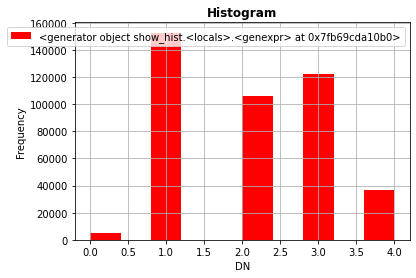

In [8]:
show_hist(labels_data)

In [9]:
# The classes are very imbalanced, so undersample the majority classes
rus = RandomUnderSampler(random_state=63)
pixels_resampled, labels_resampled = rus.fit_resample(pixels, input_labels)   
print ('Dataframe shape after undersampling of majority classes, pixels 2D: ', pixels_resampled.shape)
print ('Dataframe shape after undersampling of majority classes, labels 2D: ', labels_resampled.shape)

Dataframe shape after undersampling of majority classes, pixels 2D:  (24695, 8)
Dataframe shape after undersampling of majority classes, labels 2D:  (24695,)


Notice that we lost a lot of pixel at this point, in real cases that much be undesired. See [inbalanced-learn User guide](https://imbalanced-learn.org/stable/user_guide.html#user-guide) for other options.

### Divide the data to test and training datasets

In [10]:
x_train, x_test, y_train, y_test = train_test_split(pixels_resampled, labels_resampled, test_size=0.2, random_state=63)
print ('Training dataset: ', x_train.shape)

Training dataset:  (19756, 8)


*How many pixels of different classes are included in training dataset?*

In [11]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=uint8), array([3938, 3974, 3954, 3949, 3941]))

## Define and compile the model

In [12]:
# Initializing a sequential model
model = models.Sequential()
# adding the first layer containing 64 perceptrons. 3 is representing the number of bands used for training
model.add(layers.Dense(64, activation='relu', input_shape=(no_bands_in_image,)))
# add the first dropout layer
model.add(layers.Dropout(rate=0.2))
# adding more layers to the model
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(16, activation='relu'))
# for last layer, the activation is 'softmax', it should be that for multi-class classification models
model.add(layers.Dense(number_of_classes, activation='softmax'))

2022-09-07 12:29:50.753745: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-07 12:29:50.753783: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r18c04.bullx): /proc/driver/nvidia/version does not exist
2022-09-07 12:29:50.755119: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compile the model, using:
 - `Adam optimizer`, often used, but could be some other optimizer too.
 - Some other learning rate could be tried
 - `categorical_crossentropy` loss function (should be used with multi-class classification)

In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

Encode the labels categorically (as we did with the region names in Postcode preparations). As result each pixel has a label, which is a 1D vector with 5 elements, each representing the probability of belonging to each class.

In [14]:
y_train_categorical = to_categorical(y_train)
y_train_categorical.shape

(19756, 5)

Train the model and save it. *This takes a moment, please wait*

In [24]:
start_time = time.time() 
model.fit(x_train, y_train_categorical, epochs=500, batch_size=256, verbose=0)

# Save the model to disk
# Serialize the model to JSON
model_json = model.to_json()
with open(fullyConnectedModel, "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights(fullyConnectedWeights)
print('Saved model to disk:  \nModel: ', fullyConnectedModel, '\nWeights: ',  fullyConnectedWeights)
print('Model training took: ', round((time.time() - start_time), 0), ' seconds')

Saved model to disk:  
Model:  ../03_deep/fullyConnectedModel.json 
Weights:  ../03_deep/fullyConnectedWeights.h5
Model training took:  49.0  seconds


### Estimate the model on test data

Find accuracy using Keras own `evaluate()`-function.

In [16]:
y_test_categorical = to_categorical(y_test)

# Use verbose=0 when using this in batch jobs, avoids printing to output a lot of unclear text.
test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=1)
print('Test accuracy:', test_acc)

155/155 [==============================] - 0s 769us/step - loss: 0.6698 - accuracy: 0.7404
Test accuracy: 0.7404332756996155


Calculate confusion matrix and classification report as we did with shallow classifier. Use `scikit-learn` functions for that.

First predict for the x_test. The model returns a 2D array, with:
- each row representing one pixel.
- each column representing the probablity of this pixel representing each category

In [17]:
test_prediction = model.predict(x_test)	
print ('Test prediction dataframe shape, original 2D: ', test_prediction.shape) 

Test prediction dataframe shape, original 2D:  (4939, 5)


Find which class was most likely for each pixel and select only that class for the output. Output is 1D array, with the most likely class index given for each pixel. `Argmax` returns the indices of the maximum values 

In [18]:
predicted_classes = np.argmax(test_prediction,axis=1)
print ('Test prediction dataframe shape, after argmax, 1D: ', predicted_classes.shape)

Test prediction dataframe shape, after argmax, 1D:  (4939,)


In [19]:
print('Confusion matrix: \n', confusion_matrix(y_test, predicted_classes))
print('Classification report: \n', classification_report(y_test, predicted_classes))

Confusion matrix: 
 [[548 128  84  11 230]
 [ 48 795  34   0  88]
 [ 79  46 769   0  91]
 [ 48   2   0 935   5]
 [ 70 175 140   3 610]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.55      0.61      1001
           1       0.69      0.82      0.75       965
           2       0.75      0.78      0.76       985
           3       0.99      0.94      0.96       990
           4       0.60      0.61      0.60       998

    accuracy                           0.74      4939
   macro avg       0.74      0.74      0.74      4939
weighted avg       0.74      0.74      0.74      4939



## Predict classification based on the data image and save it

Very similar to the shallow classifiers, but:
 - `argmax` is used for finding the most likely class.
 - Data type is changed to int8, keras returns int64, which GDAL does not support.   
 
 Load the model from .json file and re-create the model.

In [20]:
json_file = open(fullyConnectedModel, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into the model
loaded_model.load_weights(fullyConnectedWeights)
print("Loaded model from disk")

Loaded model from disk


Predict for all pixels, reshape data back to image and save it as file.

In [21]:
start_time = time.time() 
# Predict for all pixels
prediction = loaded_model.predict(pixels)
print ('Prediction dataframe shape, original 2D: ', prediction.shape)

# Find the most likely class for each pixel.
predicted_classes = np.argmax(prediction,axis=1)
print ('Prediction dataframe shape, after argmax, 1D: ', predicted_classes.shape)

# Reshape back to 2D as in original raster image
prediction2D = np.reshape(predicted_classes, (image_data.shape[1], image_data.shape[2]))
print('Prediction shape in 2D: ', prediction2D.shape)

# Change data type to int8
predicted2D_int8 = np.int8(prediction2D)

# Save the results as .tif file.
# Copy the coordinate system information, image size and other metadata from the satellite image 
outputMeta = image_dataset.meta
# Change the number of bands and data type.
outputMeta.update(count=1, dtype='int8', nodata=100)
# Writing the image on the disk
with rasterio.open(predictedImageFile, 'w', **outputMeta) as dst:
    dst.write(predicted2D_int8, 1)

print('Predicting took: ', round((time.time() - start_time), 0), ' seconds')

Prediction dataframe shape, original 2D:  (422500, 5)
Prediction dataframe shape, after argmax, 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  8.0  seconds


## Plot the results

In [22]:
### Help function to normalize band values and enhance contrast. Just like what QGIS does automatically
def normalize(array):
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))
    return (array - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'labels'}>

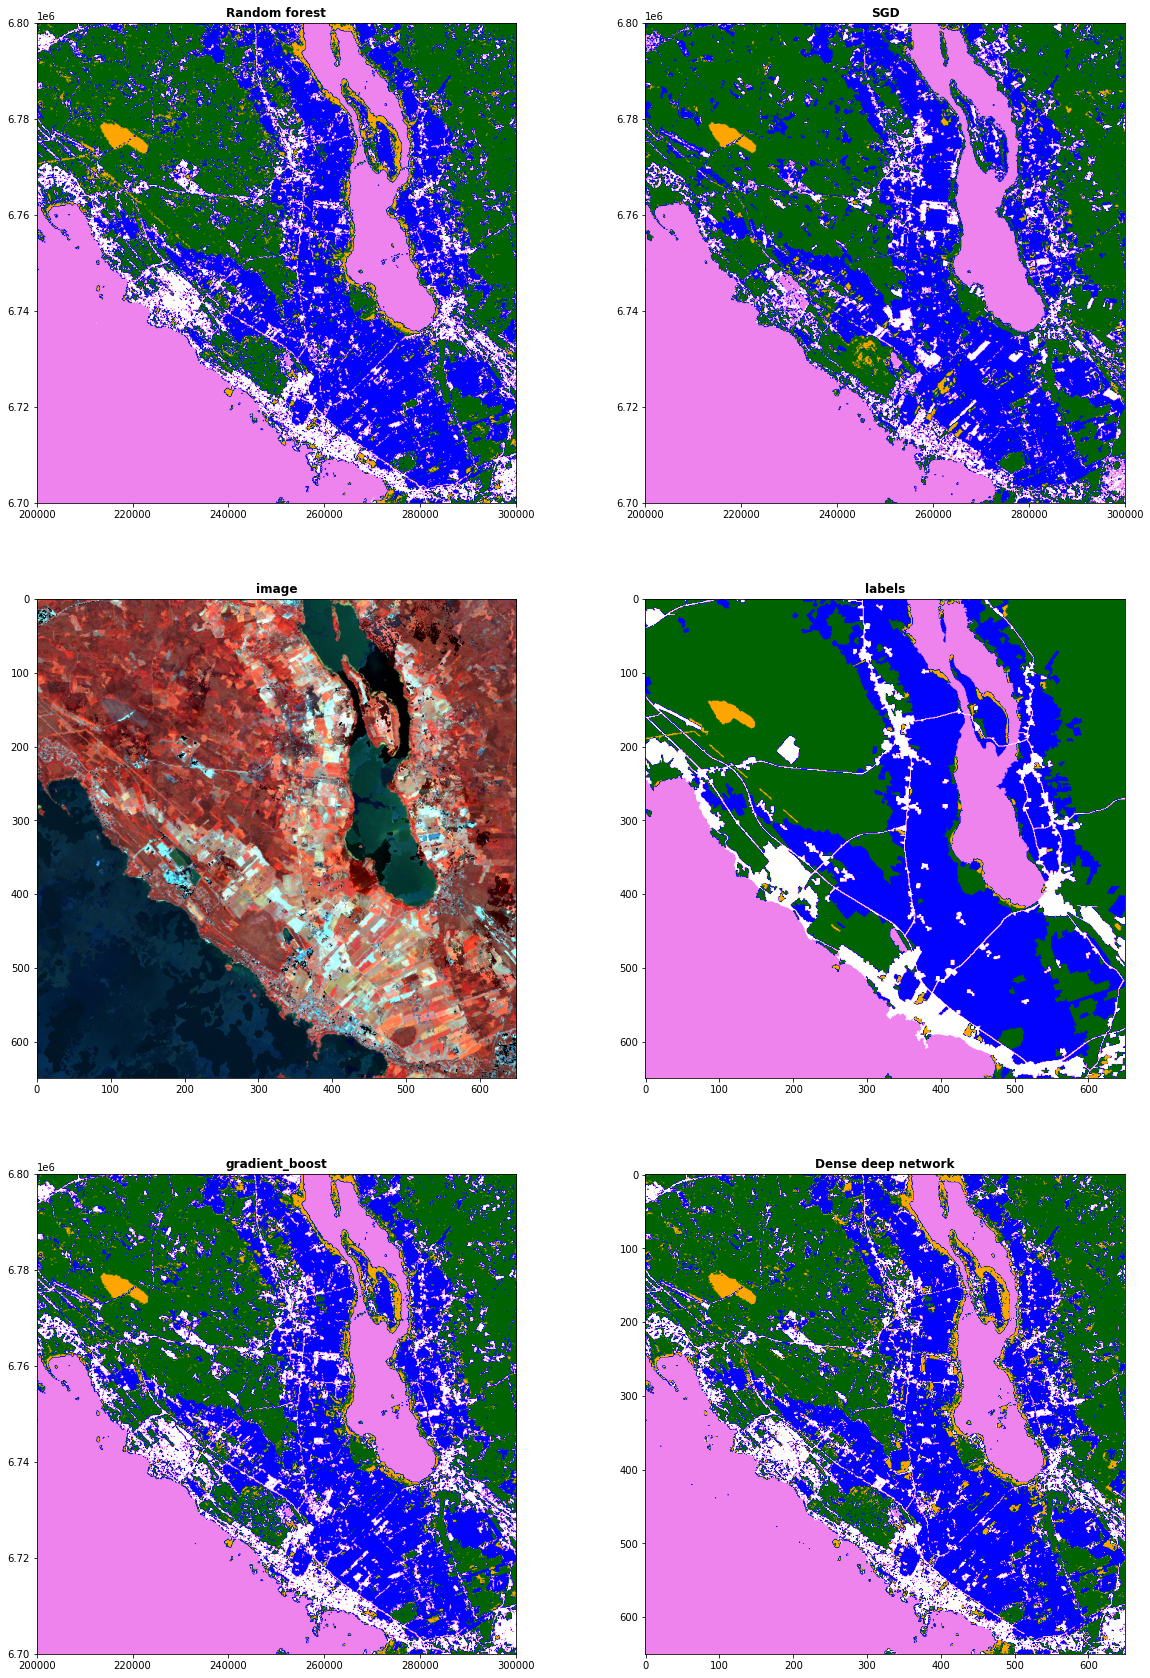

In [23]:
### Create a subplot for 4 images and plot the sentinel image 
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 30))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","darkgreen","blue","violet","white"])

### The results
rf_results = rasterio.open(random_forest_predicition)
show(rf_results, ax=ax[0, 0], cmap=cmap, title='Random forest')

SGD_results = rasterio.open(SGD_predicition)
show(SGD_results, ax=ax[0, 1], cmap=cmap, title='SGD')

gradient_boost_results = rasterio.open(gradient_boost_predicition)
show(gradient_boost_results, ax=ax[2, 0], cmap=cmap, title='gradient_boost')

show(predicted2D_int8, ax=ax[2, 1], cmap=cmap, title='Dense deep network')

# Plot the sentinel image 
nir, red, green = image_data[7,], image_data[3,], image_data[1,]
nirn, redn, greenn = normalize(nir), normalize(red), normalize(green)
stacked = np.stack((nirn, redn, greenn))
show(stacked, ax=ax[1,0], title='image') 

#labels = rasterio.open(labelsImage)
show(labels_data, ax=ax[1,1], cmap=cmap, title='labels')
